# Markstein numbers (phi = 0.4) from Cantera

This notebook mirrors `markstein_cantera_original.ipynb` but follows the paper procedure for
reference quantities, activation energy, and Markstein numbers for `phi = 0.4`.

## Scaling and reference quantities
The paper uses the thermal flame thickness and laminar flame speed as reference scales:

$$\ell_T = \frac{T_b - T_u}{\max(\nabla T)}, \quad t_{ref} = \frac{\ell_T}{S_L}$$

Reference heat release rate and mixture transport scales are:

$$\dot{Q}_u = \frac{\rho_u c_{p,u} T_u}{t_{ref}}, \quad D_{th} = \frac{\lambda_u}{\rho_u c_{p,u}}, \quad \ell_f = \frac{D_{th}}{S_L}$$

Scaled temperature and heat release rate are:

$$\Theta = \frac{T - T_u}{T_b - T_u}, \quad \Xi = \frac{\dot{Q} - \dot{Q}_u}{\dot{Q}_{max} - \dot{Q}_u}$$

Activation energy (local Arrhenius fit near peak heat release):

$$E_a = -R\,\frac{d[\ln(\dot{\omega}_T)]}{d(1/T)}$$

Zeldovich number (paper definition):

$$\beta = \frac{E_a (T_b - T_u)}{R T_b^2}$$

Markstein numbers from Eq. (30)-(31) in `markstein_cantera_original.ipynb`:

$$\alpha = \frac{\sigma}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, dx
+ \frac{\beta}{2} \frac{Le_{eff} - 1}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, \ln\left(\frac{\sigma - 1}{x - 1}\right) dx$$

$$\begin{aligned}
L_{str}^* &= \left[ \alpha \int_{1}^{\tilde{T}^*} \frac{\tilde{\lambda}(x)}{x} \, dx - \int_{\tilde{T}^*}^{\sigma} \frac{\tilde{\lambda}(x)}{x - 1} \, dx \right] \\
L_{cur}^* &= \left[ \alpha \int_{1}^{\tilde{T}^*} \frac{\tilde{\lambda}(x)}{x} \, dx \right]
\end{aligned}$$

with $x = T/T_u$, $\tilde{\lambda} = \lambda/\lambda_u$, and $\sigma = \rho_u/\rho_b$.

Effective Lewis number (Eq. 2.3):

$$Le_{eff} = \frac{Le_E + A\,Le_D}{1 + A}, \quad
A = \begin{cases}
1 + \beta(\phi^{-1} - 1), & \phi < 1 \\
1 + \beta(\phi - 1), & \phi > 1
\end{cases}$$

Here $Le_D$ and $Le_E$ are the Lewis numbers of the deficient and excess reactants, respectively.

Markstein number (Eq. 2.17) and burned Markstein number (Eq. 2.19):

$$\mathcal{M} = \frac{\sigma}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, dx
+ \frac{\beta}{2} \frac{Le_{eff} - 1}{\sigma - 1} \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, \ln\left(\frac{\sigma - 1}{x - 1}\right) dx$$

$$\mathcal{M}^b = \mathcal{M} - \int_{1}^{\sigma} \frac{\tilde{\lambda}(x)}{x} \, dx$$

with $L = \mathcal{M} \, \ell_f$ and $L^b = \mathcal{M}^b \, \ell_f$.

## Assumptions (explicit)
- 1D, steady, planar, freely propagating premixed flame at constant pressure; ideal gas.
- Transport model is mixture-averaged (Cantera default). Thermal conductivity and species
  diffusivities are taken directly from Cantera; no constant-transport simplification.
- Activation energy is from a local Arrhenius fit to the heat-release-rate profile.
- Optional override: set `USE_FIXED_EA=True` to bypass the fit and use `EA_FIXED_KCAL_PER_MOL`.
- Effective Lewis number uses fuel and oxidizer Lewis numbers at unburned conditions with
  Eq. (2.3) weighting.
- Markstein numbers are evaluated at $T^*$ where $\dot{Q}$ is maximum (corresponding to $\Theta^*$).

If you want a different activation-energy model or evaluation point for $L_{str}^*$ and
$L_{cur}^*$, adjust the settings in the next cell.


In [ ]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cantera as ct
import math
# ---------------------------
# User settings
# ---------------------------
def find_mech_path() -> Path:
    candidates = [
        Path.cwd() / 'flamekit' / 'chem_mech' / 'BurkeH2.yaml',
        Path.cwd() / 'flamekit' / 'chemical_mech' / 'BurkeH2.yaml',
        Path.cwd().parent / 'flamekit' / 'chem_mech' / 'BurkeH2.yaml',
        Path.cwd().parent / 'flamekit' / 'chemical_mech' / 'BurkeH2.yaml',
    ]
    for path in candidates:
        if path.is_file():
            return path
    raise FileNotFoundError('BurkeH2.yaml not found under flamekit/chem_mech or flamekit/chemical_mech')

MECH_PATH = find_mech_path()
PHI = 0.4
T_U = 298.0
P_U = ct.one_atm
FUEL = 'H2'
OXIDIZER = 'O2:1.0, N2:3.76'

TRANSPORT_MODEL = 'mixture-averaged'  # 'mixture-averaged' 

WIDTH = 400 * 7.478284e-04  # m
REFINE_CRIT = dict(ratio=3, slope=0.06, curve=0.12)

USE_FIXED_LEWIS = False
LE_FUEL_FIXED = 0.368
LE_OXIDIZER_FIXED = 1.395

USE_FIXED_EA = True
EA_FIXED_KCAL_PER_MOL = 37  # kcal/mol (override when USE_FIXED_EA=True)



In [ ]:
def solve_flame(phi: float, oxidizer: str, loglevel: int = 1) -> ct.FreeFlame:
    gas = ct.Solution(str(MECH_PATH))
    gas.TP = T_U, P_U
    gas.transport_model = TRANSPORT_MODEL
    gas.set_equivalence_ratio(phi, fuel=FUEL, oxidizer=oxidizer)

    flame = ct.FreeFlame(gas, width=WIDTH)
    flame.transport_model = TRANSPORT_MODEL
    flame.set_refine_criteria(**REFINE_CRIT)
    flame.solve(loglevel=loglevel, auto=True)
    return flame


def estimate_activation_energy(flame: ct.FreeFlame, window: int = 8) -> float:
    T = flame.T
    qdot = flame.heat_release_rate
    qdot = np.clip(qdot, 1e-30, None)
    idx_peak = int(np.argmax(qdot))

    i0 = max(0, idx_peak - window)
    i1 = min(len(T), idx_peak + window + 1)
    T_w = T[i0:i1]
    q_w = qdot[i0:i1]

    x = 1.0 / T_w
    y = np.log(q_w)
    slope = np.polyfit(x, y, 1)[0]
    return float(-slope * ct.gas_constant)


def lewis_numbers_unburned(phi: float) -> dict:
    gas = ct.Solution(str(MECH_PATH))
    gas.TP = T_U, P_U
    gas.transport_model = TRANSPORT_MODEL
    gas.set_equivalence_ratio(phi, fuel=FUEL, oxidizer=OXIDIZER)

    k_u = gas.thermal_conductivity
    rho_u = gas.density
    cp_u = gas.cp_mass
    d_th_u = k_u / (rho_u * cp_u)

    d_mix = gas.mix_diff_coeffs
    i_fuel = gas.species_index(FUEL)
    i_ox = gas.species_index('O2')

    le_f = d_th_u / d_mix[i_fuel]
    le_o = d_th_u / d_mix[i_ox]
    return {
        'Le_fuel': float(le_f),
        'Le_oxidizer': float(le_o),
    }


def effective_lewis_number(phi: float, beta: float, le_fuel: float, le_oxidizer: float) -> float:
    if phi < 1.0:
        le_d = le_fuel
        le_e = le_oxidizer
        A = 1.0 + beta * (1.0 / phi - 1.0)
    elif phi > 1.0:
        le_d = le_oxidizer
        le_e = le_fuel
        A = 1.0 + beta * (phi - 1.0)
    else:
        le_d = le_fuel
        le_e = le_oxidizer
        A = 1.0
    return (le_e + A * le_d) / (1.0 + A)


def compute_reference_quantities(flame: ct.FreeFlame) -> dict:
    T = flame.T
    grid = flame.grid
    rho = flame.density
    k = flame.thermal_conductivity
    cp = flame.cp_mass
    qdot = flame.heat_release_rate

    T_b = float(T[-1])
    T_u = float(T[0])
    S_L = float(flame.velocity[0])
    rho_u = float(rho[0])
    rho_b = float(rho[-1])
    sigma = rho_u / rho_b

    dTdx = np.gradient(T, grid)
    max_grad = float(np.max(np.abs(dTdx)))
    l_T = (T_b - T_u) / max_grad
    t_ref = l_T / S_L

    k_u = float(k[0])
    cp_u = float(cp[0])
    d_th_u = k_u / (rho_u * cp_u)
    l_f = d_th_u / S_L

    Qdot_u = rho_u * cp_u * T_u / t_ref
    Qdot_max = float(np.max(qdot))
    i_qmax = int(np.argmax(qdot))
    T_star = float(T[i_qmax])
    theta_star = (T_star - T_u) / (T_b - T_u)

    Theta = (T - T_u) / (T_b - T_u)
    Xi = (qdot - Qdot_u) / (Qdot_max - Qdot_u)

    return {
        'T_u': T_u,
        'T_b': T_b,
        'S_L': S_L,
        'rho_u': rho_u,
        'rho_b': rho_b,
        'sigma': sigma,
        'l_T': l_T,
        't_ref': t_ref,
        'D_th': d_th_u,
        'l_f': l_f,
        'Qdot_u': Qdot_u,
        'Qdot_max': Qdot_max,
        'T_star': T_star,
        'theta_star': theta_star,
        'T': T,
        'qdot': qdot,
        'Theta': Theta,
        'Xi': Xi,
        'k': k,
        'cp': cp,
    }


In [ ]:
# Solve base flame (phi = 0.4)
flame = solve_flame(PHI, OXIDIZER, loglevel=1)
refs = compute_reference_quantities(flame)

# Fixed Ea
if USE_FIXED_EA:
    E_a = EA_FIXED_KCAL_PER_MOL * 4184.0 * 1000.0  # J/kmol
    ls_points = None
else:
    E_a = estimate_activation_energy(flame)
    ls_points = None
beta = E_a * (refs['T_b'] - refs['T_u']) / (ct.gas_constant * refs['T_b'] * refs['T_b'])

lewis = lewis_numbers_unburned(PHI)
if USE_FIXED_LEWIS:
    le_fuel = LE_FUEL_FIXED
    le_oxidizer = LE_OXIDIZER_FIXED
else:
    le_fuel = lewis['Le_fuel']
    le_oxidizer = lewis['Le_oxidizer']
le_eff = effective_lewis_number(PHI, beta, le_fuel, le_oxidizer)

print('Reference quantities (phi = 0.4)')
print(f"T_b = {refs['T_b']:.2f} K")
print(f"S_L = {refs['S_L']:.6f} m/s")
print(f"S_L = {refs['S_L']*100.0:.6f} cm/s")
print(f"l_T = {refs['l_T']*100.0:.6e} cm")
print(f"l_T = {refs['l_T']:.6e} m, t_ref = {refs['t_ref']:.6e} s")
print(f"sigma = {refs['sigma']:.4f}")
print(f"D_th = {refs['D_th']:.6e} m^2/s, l_f = {refs['l_f']:.6e} m")
print(f"Qdot_u = {refs['Qdot_u']:.6e} W/m^3")
print(f"Qdot_max = {refs['Qdot_max']:.6e} W/m^3")
print(f"T_star = {refs['T_star']:.2f} K, theta_star = {refs['theta_star']:.4f}")
print()
print('Activation energy and Lewis numbers')
label = 'fixed' if USE_FIXED_EA else 'local-fit'
print(f"E_a ({label}) = {E_a / (4184.0 * 1000.0):.6f} kcal/mol")
print(f"beta = {beta:.4f}")
print(f"Le_fuel = {le_fuel:.3f}, Le_oxidizer = {le_oxidizer:.3f}, Le_eff = {le_eff:.3f}")



************ Solving on 8 point grid with energy equation enabled ************

..............................................................................

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0002563  log(ss)= 2.377     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.006568   log(ss)= 2.544     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.1683     log(ss)= 2.341     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.00632    log(ss)= 2.996     

Attempt Newton solution of steady-state problem.
Newton steady-state solve failed.

Attempt 10 timesteps.
Final timestep info: dt= 0.0004745  log(ss)= 4.111     

Attempt Newton solution 

In [4]:
# Markstein numbers using Eq. (30)-(31)
T = refs['T']
k = refs['k']
T_u = refs['T_u']
T_b = refs['T_b']
k_u = float(k[0])
sigma = refs['sigma']

x = T / T_u
progress = (T - T_u) / (T_b - T_u)
lam_tilde = k / k_u

eps = 1e-4
mask = x > (1.0 + eps)
x = x[mask]
lam_tilde = lam_tilde[mask]
progress = progress[mask]
T_sorted = T[mask]

order = np.argsort(x)
x = x[order]
lam_tilde = lam_tilde[order]
progress = progress[order]
T_sorted = T_sorted[order]

def cumtrapz(y: np.ndarray, x: np.ndarray) -> np.ndarray:
    dx = np.diff(x)
    area = 0.5 * (y[1:] + y[:-1]) * dx
    return np.concatenate(([0.0], np.cumsum(area)))

f1 = lam_tilde / x
I1 = cumtrapz(f1, x)

f2 = lam_tilde / (x - 1.0)
I2_cum = cumtrapz(f2, x)
I2_total = float(I2_cum[-1])
I2 = I2_total - I2_cum

f2_ln = lam_tilde / x * np.log((sigma - 1.0) / (x - 1.0))
I2_ln = cumtrapz(f2_ln, x)
I2_ln_total = float(I2_ln[-1])

I1_total = float(I1[-1])
alpha = (sigma / (sigma - 1.0)) * I1_total + 0.5 * beta * (le_eff - 1.0) / (sigma - 1.0) * I2_ln_total

# Markstein number M (Eq. 2.17) and burned Markstein number M_b (Eq. 2.19)
M = alpha
M_b = M - I1_total
print(f"Markstein number M = {M:.6f}")
print(f"Burned Markstein number M_b = {M_b:.6f}")

L_str = (alpha * I1 - I2)
L_cur = (alpha * I1)

x_star = refs['T_star'] / refs['T_u']
L_str_star = float(np.interp(x_star, x, L_str))
L_cur_star = float(np.interp(x_star, x, L_cur))

print('Markstein numbers at T* (Qdot max)')
print(f"L_str* = {L_str_star:.6e}")
print(f"L_cur* = {L_cur_star:.6e}")

# Save outputs
out_dir = Path.cwd() / 'data' / 'Markstein lengths'
out_dir.mkdir(parents=True, exist_ok=True)
p_atm = P_U / ct.one_atm
out_name = f'markstein_phi_{PHI:.2f}_Tu_{T_U:.0f}K_P_{p_atm:.2f}atm.csv'
out_path = out_dir / out_name
df_out = pd.DataFrame({
    'progress': progress,
    'T': T_sorted,
    'L_cur': L_cur,
    'L_str': L_str,
    'M': np.full_like(progress, M),
    'M_b': np.full_like(progress, M_b),
})
df_out.to_csv(out_path, index=False)

ref_dir = Path.cwd() / 'data' / 'Reference quantities'
ref_dir.mkdir(parents=True, exist_ok=True)
ref_path = ref_dir / f'ref_phi_{PHI:.2f}_Tu_{T_U:.0f}K_P_{p_atm:.2f}atm.csv'
pd.DataFrame([
    {
        'phi': PHI,
        'T_u': refs['T_u'],
        'T_b': refs['T_b'],
        'S_L': refs['S_L'],
        'l_T': refs['l_T'],
        't_ref': refs['t_ref'],
        'Qdot_u': refs['Qdot_u'],
        'Qdot_max': refs['Qdot_max'],
        'T_star': refs['T_star'],
        'theta_star': refs['theta_star'],
        'sigma': refs['sigma'],
        'D_th': refs['D_th'],
        'l_f': refs['l_f'],
        'E_a': E_a,
        'beta': beta,
        'Le_fuel': lewis['Le_fuel'],
        'Le_oxidizer': lewis['Le_oxidizer'],
        'Le_eff': le_eff,
        'L_str_star': L_str_star,
        'L_cur_star': L_cur_star,
        'M': M,
        'M_b': M_b,
    }
]).to_csv(ref_path, index=False)

print(f"Saved Markstein profile to: {out_path}")
print(f"Saved reference quantities to: {ref_path}")


Markstein number M = 0.852962
Burned Markstein number M_b = -1.504300
Markstein numbers at T* (Qdot max)
L_str* = 9.151502e-01
L_cur* = 1.579642e+00
Saved Markstein profile to: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/Markstein lengths/markstein_phi_0.40_Tu_298K_P_1.00atm.csv
Saved reference quantities to: /media/alexandros/OS/Users/alexp/Documents/Bachelor Thesis/Code/data/Reference quantities/ref_phi_0.40_Tu_298K_P_1.00atm.csv


In [5]:
# Query values at a chosen progress variable
PROGRESS_QUERY = 0.6  # set between 0 and 1

if not (0.0 <= PROGRESS_QUERY <= 1.0):
    raise ValueError('PROGRESS_QUERY must be between 0 and 1.')

T_q = float(np.interp(PROGRESS_QUERY, progress, T_sorted))
L_str_q = float(np.interp(PROGRESS_QUERY, progress, L_str))
L_cur_q = float(np.interp(PROGRESS_QUERY, progress, L_cur))

print(f"Progress variable = {PROGRESS_QUERY:.3f}")
print(f"T(PROGRESS_QUERY) = {T_q:.2f} K")
print(f"L_str(PROGRESS_QUERY) = {L_str_q:.6e}")
print(f"L_cur(PROGRESS_QUERY) = {L_cur_q:.6e}")
print(f"M = {M:.6f}")
print(f"M_b = {M_b:.6f}")


Progress variable = 0.600
T(PROGRESS_QUERY) = 951.46 K
L_str(PROGRESS_QUERY) = 1.873615e-01
L_cur(PROGRESS_QUERY) = 1.304977e+00
M = 0.852962
M_b = -1.504300


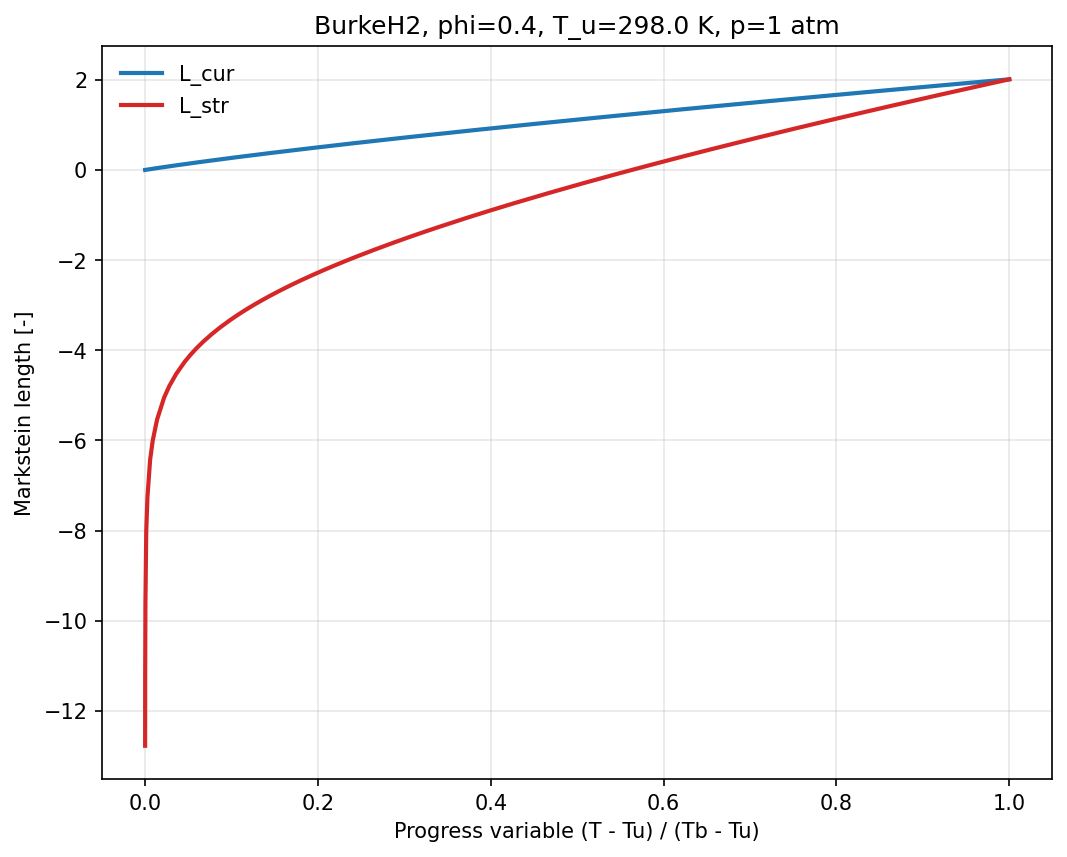

In [6]:
# Plot Markstein numbers vs progress variable
fig, ax = plt.subplots(figsize=(7.0, 5.6), dpi=150, constrained_layout=True)
ax.plot(progress, L_cur, label='L_cur', color='#1f77b4', linewidth=2.0)
ax.plot(progress, L_str, label='L_str', color='#d62728', linewidth=2.0)
ax.set_xlabel('Progress variable (T - Tu) / (Tb - Tu)')
ax.set_ylabel('Markstein length [-]')
ax.set_title(f'BurkeH2, phi={PHI}, T_u={T_U} K, p=1 atm')
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
plt.show()


    phi     sigma  lambda_bar_b         M       M_b
0  0.40  4.308468      2.522125  0.852962 -1.504300
1  0.50  4.913227      2.740388  1.680032 -1.070114
2  0.75  6.139336      3.175464  3.506223 -0.154168
3  1.00  6.870903      3.483658  5.316039  1.043246


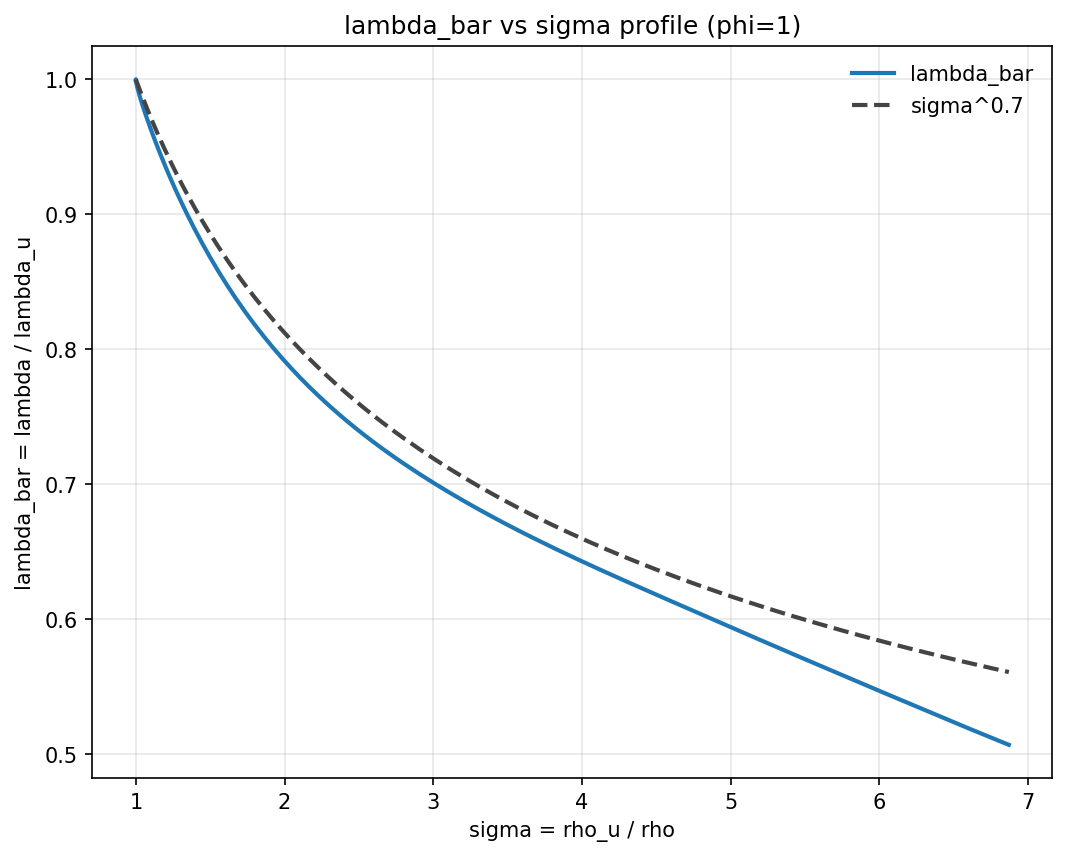

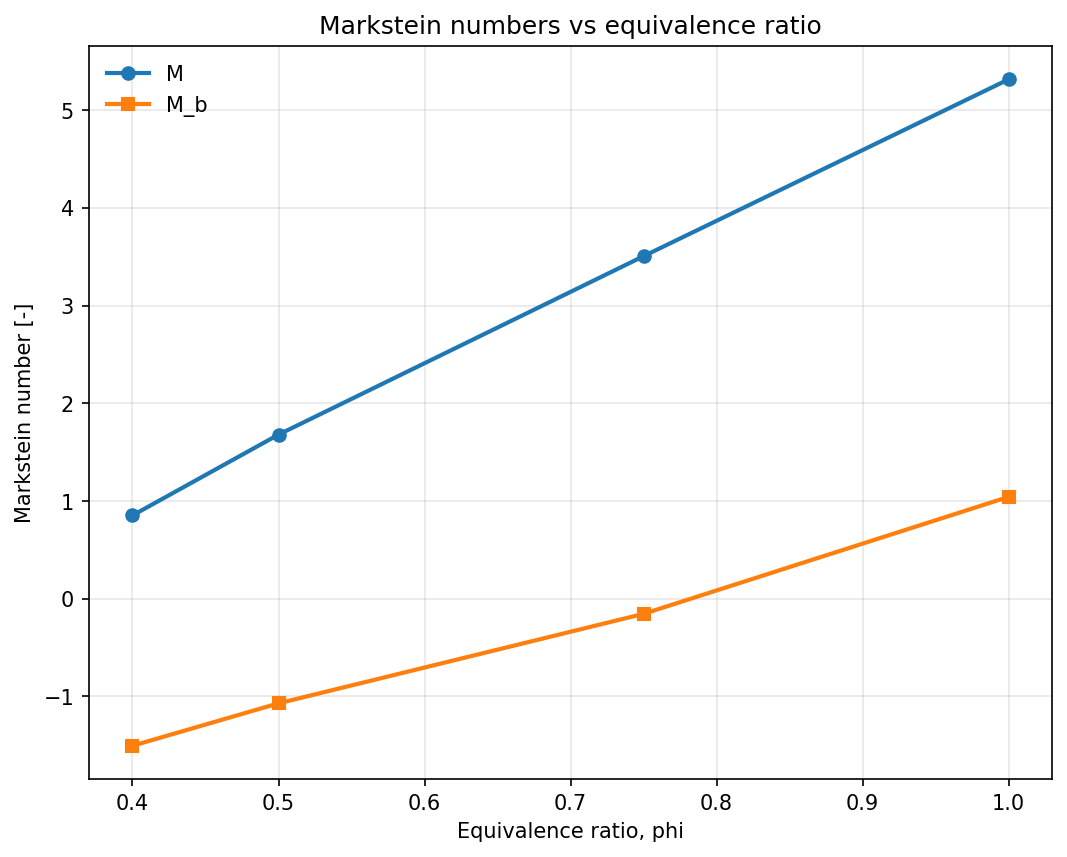

In [8]:
# Sweep equivalence ratios: k_u vs sigma and Markstein numbers vs phi
PHI_SWEEP = [0.4, 0.5, 0.75, 1.0]
PHI_PROFILE = 1  # phi used for lambda_bar vs sigma profile
SWEEP_LOGLEVEL = 0


def compute_m_m_b_for_phi(phi: float) -> dict:
    flame = solve_flame(phi, OXIDIZER, loglevel=SWEEP_LOGLEVEL)
    refs_phi = compute_reference_quantities(flame)

    if USE_FIXED_EA:
        E_a = EA_FIXED_KCAL_PER_MOL * 4184.0 * 1000.0  # J/kmol
    else:
        E_a = estimate_activation_energy(flame)

    beta_phi = E_a * (refs_phi['T_b'] - refs_phi['T_u']) / (
        ct.gas_constant * refs_phi['T_b'] * refs_phi['T_b']
    )
    lewis_phi = lewis_numbers_unburned(phi)
    le_eff_phi = effective_lewis_number(
        phi, beta_phi, lewis_phi['Le_fuel'], lewis_phi['Le_oxidizer']
    )

    T = refs_phi['T']
    k = refs_phi['k']
    T_u = refs_phi['T_u']
    sigma = refs_phi['sigma']
    k_u = float(k[0])
    lam_tilde = k / k_u
    lambda_bar_b = float(lam_tilde[-1])

    x = T / T_u

    eps = 1e-4
    mask = x > (1.0 + eps)
    x = x[mask]
    lam_tilde = lam_tilde[mask]

    order = np.argsort(x)
    x = x[order]
    lam_tilde = lam_tilde[order]

    def cumtrapz_local(y: np.ndarray, x: np.ndarray) -> np.ndarray:
        dx = np.diff(x)
        area = 0.5 * (y[1:] + y[:-1]) * dx
        return np.concatenate(([0.0], np.cumsum(area)))

    f1 = lam_tilde / x
    I1 = cumtrapz_local(f1, x)
    I1_total = float(I1[-1])

    f2_ln = lam_tilde / x * np.log((sigma - 1.0) / (x - 1.0))
    I2_ln = cumtrapz_local(f2_ln, x)
    I2_ln_total = float(I2_ln[-1])

    M = (sigma / (sigma - 1.0)) * I1_total + 0.5 * beta_phi * (le_eff_phi - 1.0) / (sigma - 1.0) * I2_ln_total
    M_b = M - I1_total

    return {
        'phi': phi,
        'sigma': sigma,
        'lambda_bar_b': lambda_bar_b,
        'M': M,
        'M_b': M_b,
    }


sweep_rows = [compute_m_m_b_for_phi(phi) for phi in PHI_SWEEP]
sweep_df = pd.DataFrame(sweep_rows)
print(sweep_df)

# Plot 1: lambda_bar vs local sigma profile for a single phi
flame_profile = solve_flame(PHI_PROFILE, OXIDIZER, loglevel=SWEEP_LOGLEVEL)

rho_prof = flame_profile.density
k_prof = flame_profile.thermal_conductivity
rho_u_prof = float(rho_prof[0])
k_u_prof = float(k_prof[0])

sigma_profile = rho_u_prof / rho_prof
lambda_bar_profile = k_prof / k_u_prof

# Sort by sigma for a clean curve
order_prof = np.argsort(sigma_profile)
sigma_profile = sigma_profile[order_prof]
lambda_bar_profile = lambda_bar_profile[order_prof]

fig, ax = plt.subplots(figsize=(7.0, 5.6), dpi=150, constrained_layout=True)
ax.plot(sigma_profile, lambda_bar_profile / sigma_profile, linewidth=2.0, label='lambda_bar')
ax.plot(sigma_profile, sigma_profile **(-0.3), linestyle='--', color='#444444', linewidth=2.0, label='sigma^0.7')

ax.set_xlabel('sigma = rho_u / rho')
ax.set_ylabel('lambda_bar = lambda / lambda_u')
ax.set_title(f'lambda_bar vs sigma profile (phi={PHI_PROFILE})')
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
plt.show()

# Plot 2: Markstein number and burned Markstein number vs phi
fig, ax = plt.subplots(figsize=(7.0, 5.6), dpi=150, constrained_layout=True)
ax.plot(sweep_df['phi'], sweep_df['M'], marker='o', linewidth=2.0, label='M')
ax.plot(sweep_df['phi'], sweep_df['M_b'], marker='s', linewidth=2.0, label='M_b')
ax.set_xlabel('Equivalence ratio, phi')
ax.set_ylabel('Markstein number [-]')
ax.set_title('Markstein numbers vs equivalence ratio')
ax.grid(True, alpha=0.3)
ax.legend(frameon=False)
plt.show()
